# Example Case of UKF and AUKF

Author: Seongchun Yang

Affiliation: Kyoto University

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys; sys.path.append('./')

np.random.seed(1)

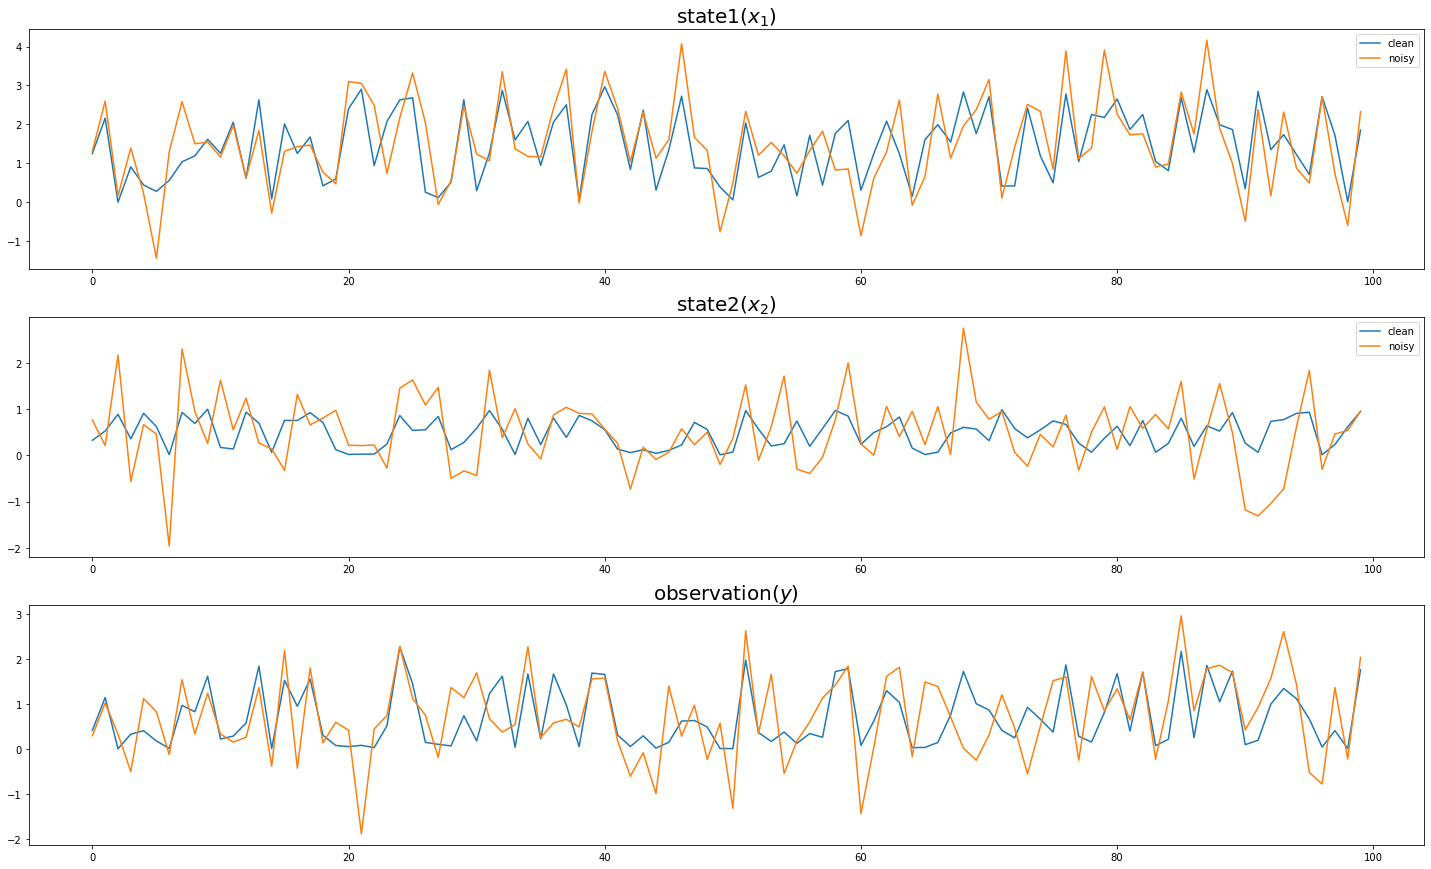

In [2]:
# simulate data
# In order to test UKF, we are simulating a case where two sets of observations are available.
# However, one of the causes behind one of the observation class are not captured, and is being estimated.
# i.e., x1 X x2 = y where x2,y is known but x1 isn't.
n = 100
x1_clean = np.random.rand(n,) * 3
x2_clean = np.random.rand(n,)
# state: x1,x2 considered to come from two different sensors, thus with uncorrelated white-noise.
x1_noisy = np.array([np.random.normal(i,np.sqrt(0.5),1) for i in x1_clean]) 
x2_noisy = np.array([np.random.normal(i,np.sqrt(0.5),1) for i in x2_clean])
# observation: non-linear (multiplicative) relationship between x1,x2
y_clean = np.multiply(x1_clean,x2_clean)
y_noisy = np.array([np.random.normal(i,np.sqrt(0.5),1) for i in y_clean])

fig=plt.figure(figsize=(25,15))

ax1=fig.add_subplot(311)
ax1.plot(x1_clean,label='clean')
ax1.plot(x1_noisy,label='noisy')
ax1.legend()
ax1.set_title('state1'+r'$(x_1)$',size=20)

ax2=fig.add_subplot(312)
ax2.plot(x2_clean,label='clean')
ax2.plot(x2_noisy,label='noisy')
ax2.legend()
ax2.set_title('state2'+r'$(x_2)$',size=20)

ax3=fig.add_subplot(313)
ax3.plot(y_clean,label='clean')
ax3.plot(y_noisy,label='noisy')
ax3.set_title('observation'+r'$(y)$',size=20)

# package
state_noisy = np.array([x1_noisy.ravel(),x2_noisy.ravel()]).T
obs_noisy = np.array([x2_noisy.ravel(),y_noisy.ravel()]).T

# UKF

In [3]:
from KF.UKF import UnscentedKalmanFilter
from filterpy.kalman import MerweScaledSigmaPoints

In [4]:
# initialize object
# initial conditions are not built in s.t. the user can decide to either;
# case[1] : directly use z0,P0 as previous updated z0,P0
# case[2] : use z0,P0 as the current time prediction of state
# Here, case[1] is being used.
UKF = UnscentedKalmanFilter(
    dim_z       =   2,
    dim_x       =   2,
    z0          =   state_noisy[0,:],
    P0          =   np.eye(2),
    fx          =   lambda x: x,
    hx          =   lambda x: np.array([x[0]*x[1],x[1]]),
    points_fn   =   MerweScaledSigmaPoints(
        n = 2,
        kappa = 1,
        alpha = 0.001,
        beta = 2
    ),
    Q           =   np.eye(2),
    R           =   np.eye(2),
)
# run UKF
zs = np.empty([n,2])
Ps = np.empty([n,2,2])
innovations = np.empty([n,2])
log_likelihoods = np.empty(n)

for i in range(n):
    UKF.predict()
    UKF.update(obs_noisy[i,:])
    zs[i,:]=UKF.z_updated
    Ps[i,:,:]=UKF.P_updated
    innovations[i]=UKF.innovation
    log_likelihoods[i]=UKF.log_likelihood

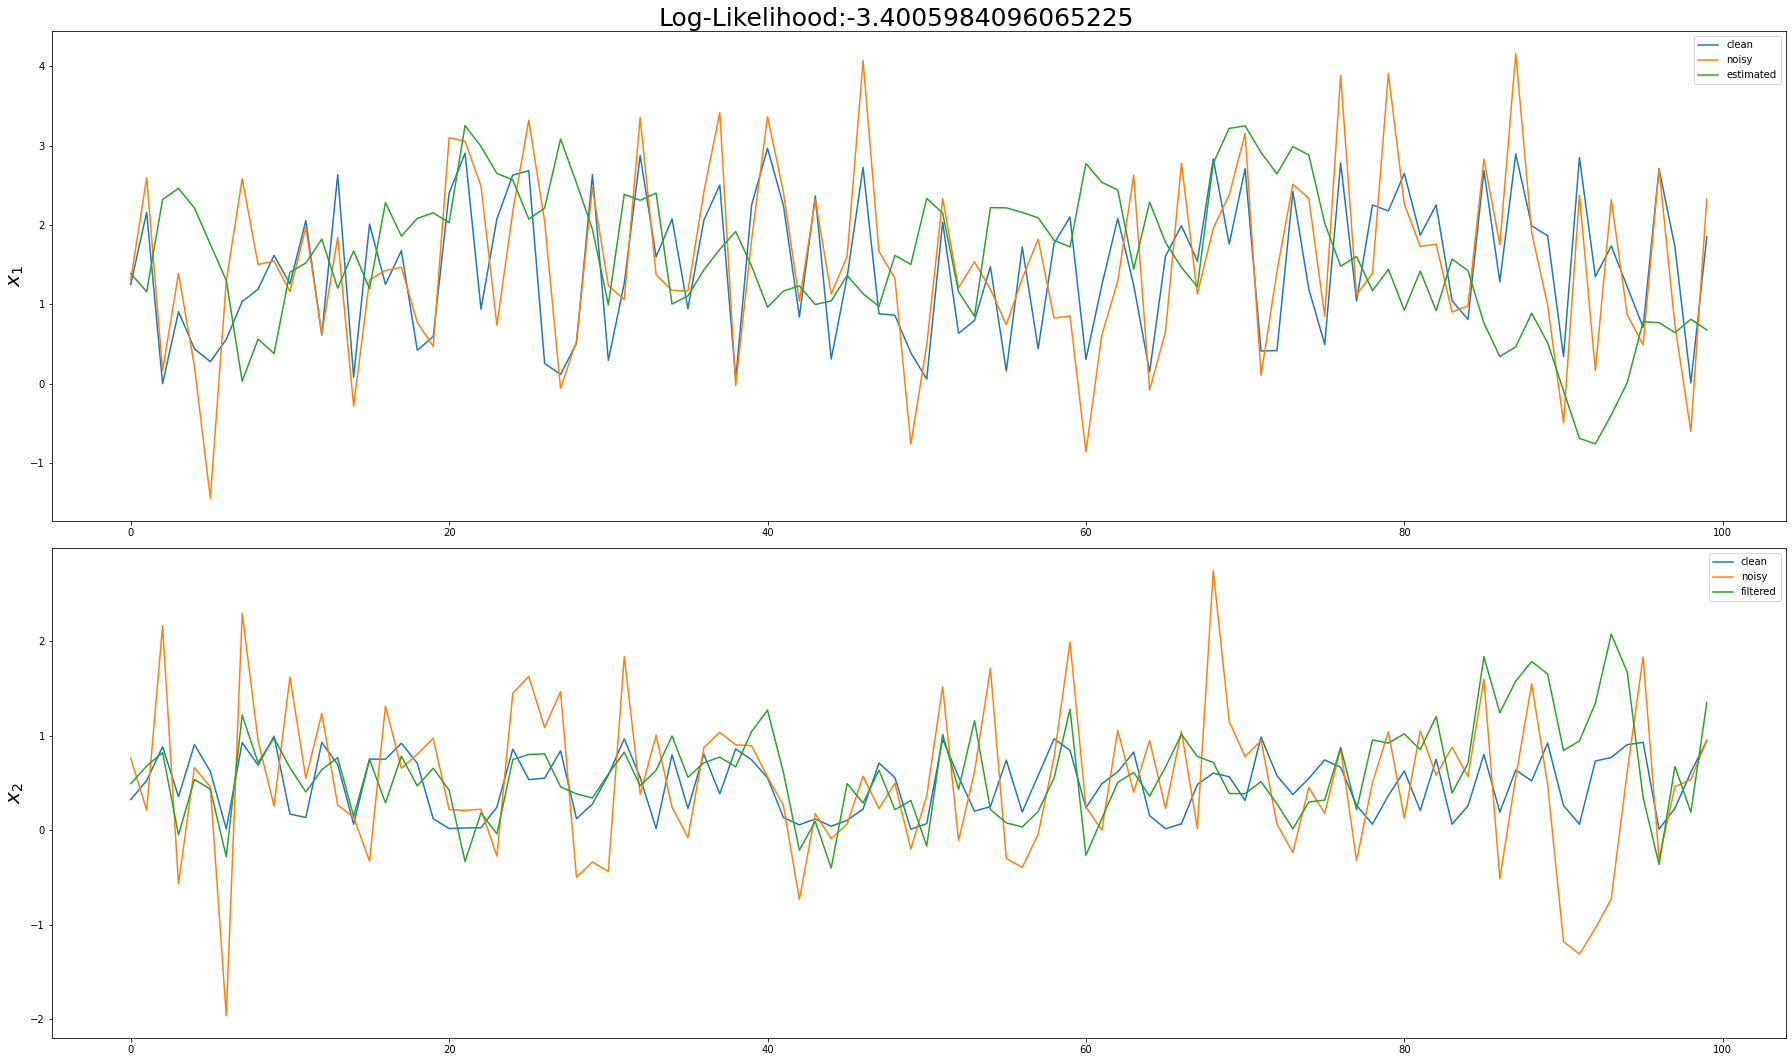

In [5]:
fig=plt.figure(figsize=(25,15))
fig.suptitle('Log-Likelihood:{}'.format(np.mean(log_likelihoods)),size=25)
# estimated x1
ax1=fig.add_subplot(211)
ax1.plot(x1_clean,label='clean')
ax1.plot(x1_noisy,label='noisy')
ax1.plot(zs[:,0],label='estimated')
ax1.set_ylabel(r'$x_1$',size=20,weight='bold')
ax1.legend()
# filtered x2
ax2=fig.add_subplot(212)
ax2.plot(x2_clean,label='clean')
ax2.plot(x2_noisy,label='noisy')
ax2.plot(zs[:,1],label='filtered')
ax2.set_ylabel(r'$x_2$',size=20,weight='bold')
ax2.legend()
fig.tight_layout()

# Adaptive UKF

In [6]:
from KF.AUKF import adaptiveUKF

In [7]:
# initialize object
AUKF = adaptiveUKF(
    n           =   n,
    delta       =   0.5,
    dim_z       =   2,
    dim_x       =   2,
    z0          =   state_noisy[0,:],
    P0          =   np.eye(2),
    fx          =   lambda x: x,
    hx          =   lambda x: np.array([x[0]*x[1],x[1]]),
    points_fn   =   MerweScaledSigmaPoints(
        n = 2,
        kappa = 1,
        alpha = 0.001,
        beta = 2
    ),
    Q           =   np.eye(2),
    R           =   np.eye(2)
)
# run AUKF
zs = np.empty([n,2])
Ps = np.empty([n,2,2])
Rs = np.empty([n,2,2])
innovations = np.empty([n,2])
log_likelihoods = np.empty(n)
for i in range(n):
    AUKF.predict()
    AUKF.update(obs_noisy[i,:])
    zs[i,:]=AUKF.z_updated
    Ps[i,:,:]=AUKF.P_updated
    Rs[i,:,:]=AUKF.R
    innovations[i]=AUKF.innovation
    log_likelihoods[i]=AUKF.log_likelihood
    # adapt measurement-noise
    AUKF.adapt_R(i,obs_noisy[i,:])

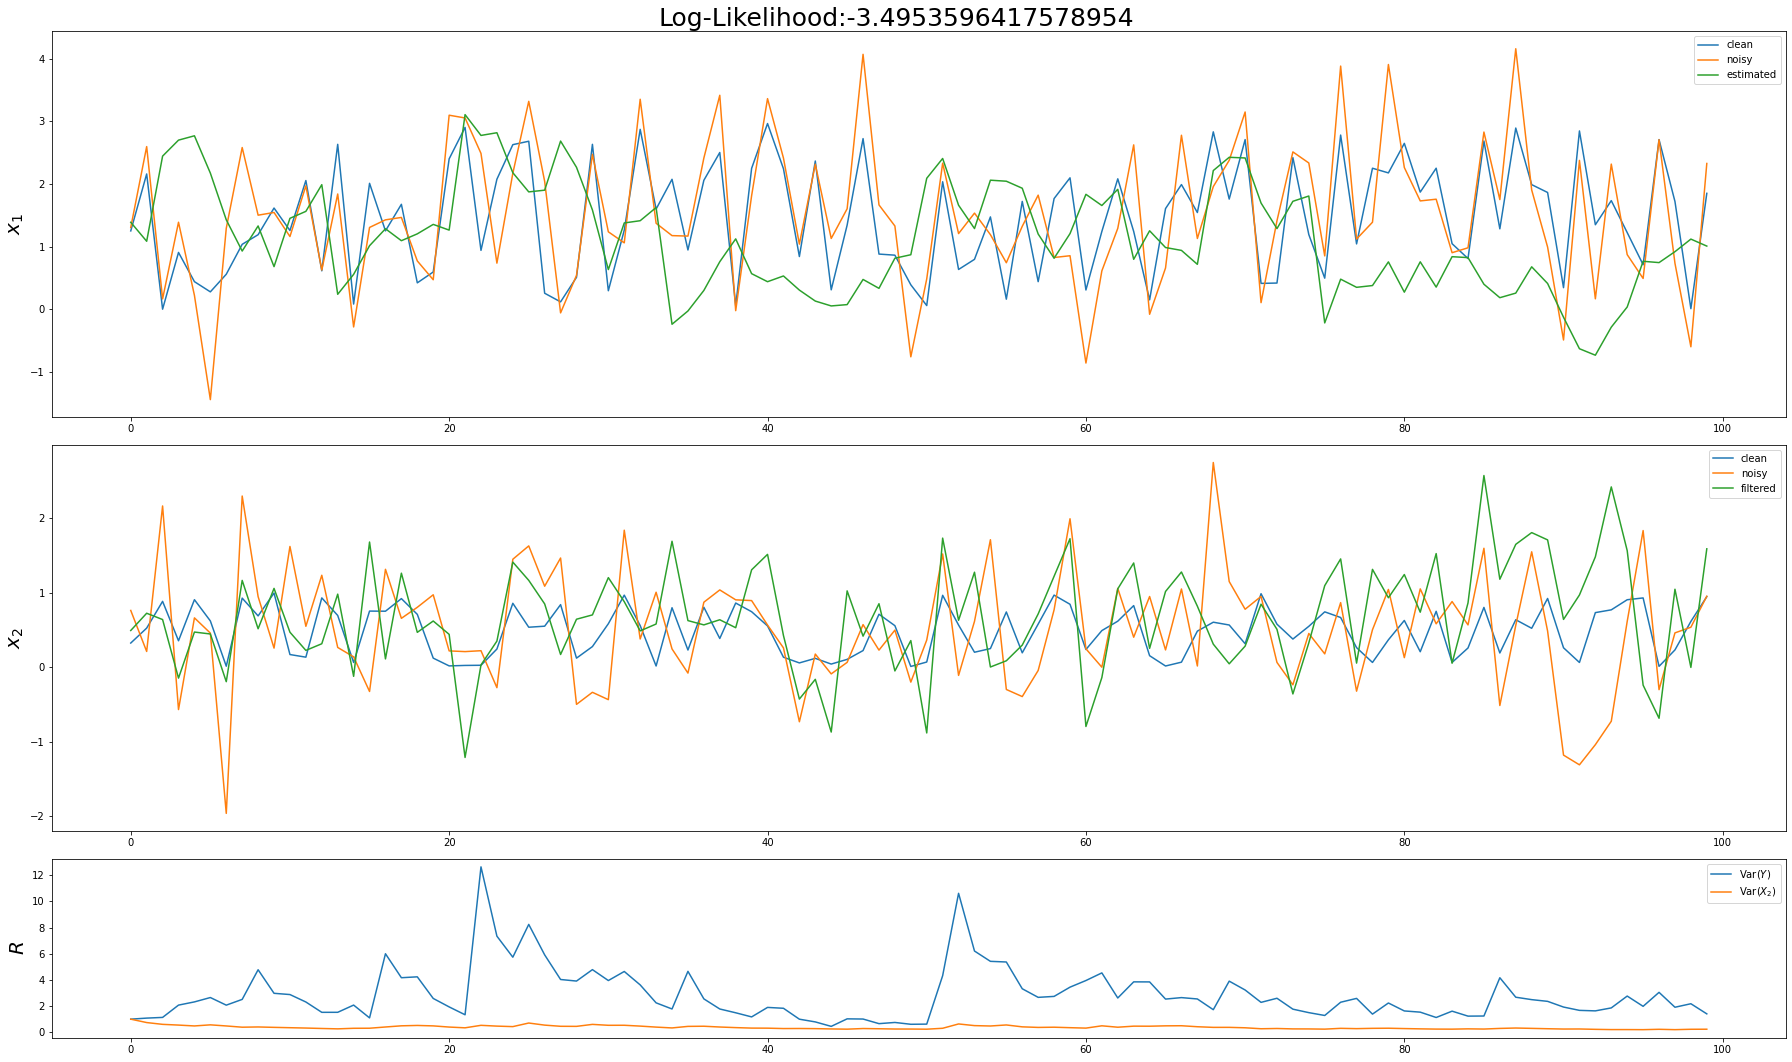

In [8]:
fig=plt.figure(figsize=(25,15))
grid = gridspec.GridSpec(nrows=5,ncols=1,figure=fig)
fig.suptitle('Log-Likelihood:{}'.format(np.mean(log_likelihoods)),size=25)
# estimated x1
ax1=fig.add_subplot(grid[0:2,0])
ax1.plot(x1_clean,label='clean')
ax1.plot(x1_noisy,label='noisy')
ax1.plot(zs[:,0],label='estimated')
ax1.set_ylabel(r'$x_1$',size=20,weight='bold')
ax1.legend()
# filtered x2
ax2=fig.add_subplot(grid[2:4,0])
ax2.plot(x2_clean,label='clean')
ax2.plot(x2_noisy,label='noisy')
ax2.plot(zs[:,1],label='filtered')
ax2.set_ylabel(r'$x_2$',size=20,weight='bold')
ax2.legend()
# Measurement noise
ax3=fig.add_subplot(grid[4,0])
ax3.plot(Rs[:,0,0],label='Var'+r'$(Y)$')
ax3.plot(Rs[:,1,1],label='Var'+r'$(X_2)$')
ax3.set_ylabel(r'$R$',size=20,weight='bold')
ax3.legend()
fig.tight_layout()

It is noteworthy that while this example is meant to showcase the effect of both UKF and AUKF, the effect is very slight. This is to be expected since our simulated data does not contain differing degree of sensor noise.